In [3]:
import os
import json
import itertools
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cf

from scipy.optimize import curve_fit

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

In [4]:
product, time_reso = 'IMERG', '3h'

In [5]:
yy_s, yy_e = 2002, 2012

In [6]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : IMERG_3h.json
Number of threads: 22
Neighborhood area: 5x5



In [7]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [8]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_simple.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [9]:
print(f'Reading data: {param['file']}')
dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data
lon2d, lat2d = np.meshgrid(lons, lats)

PRE_mean = PRE_data['PRE'].mean(dim='time')

Reading data: IMERG_Italy_3h_2001_01_01_2023_12_31.nc


In [10]:
def calcular_area_mosaico(lon_min, lon_max, lat_min, lat_max,resolucion,km_por_grado):
    resolucion = 0.1  # Resolución del satélite en grados
    km_por_grado = 11  # Aproximación de km por grado en latitud

    # Dimensiones del mosaico
    lon_min, lon_max = 10.5, 13.5
    lat_min, lat_max = 44.5, 47

    # Número de celdas
    num_celdas_lon = int((lon_max - lon_min) / resolucion)
    num_celdas_lat = int((lat_max - lat_min) / resolucion)

    # Calcular área total
    area_total_km2 = num_celdas_lon * num_celdas_lat * (km_por_grado ** 2)
    return area_total_km2

In [11]:
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47
area_km2 = calcular_area_mosaico(lon_min, lon_max, lat_min, lat_max, 0.1, 11)
area_km2

90750

In [12]:
lon_min_total, lon_max_total = 6.5, 19
lat_min_total, lat_max_total = 36.5,48

delta_lon = 1.5
delta_lat = 1.55

lon_edges = np.arange(lon_min_total, lon_max_total+delta_lon, delta_lon)
lat_edges = np.arange(lat_min_total, lat_max_total+delta_lat, delta_lat)

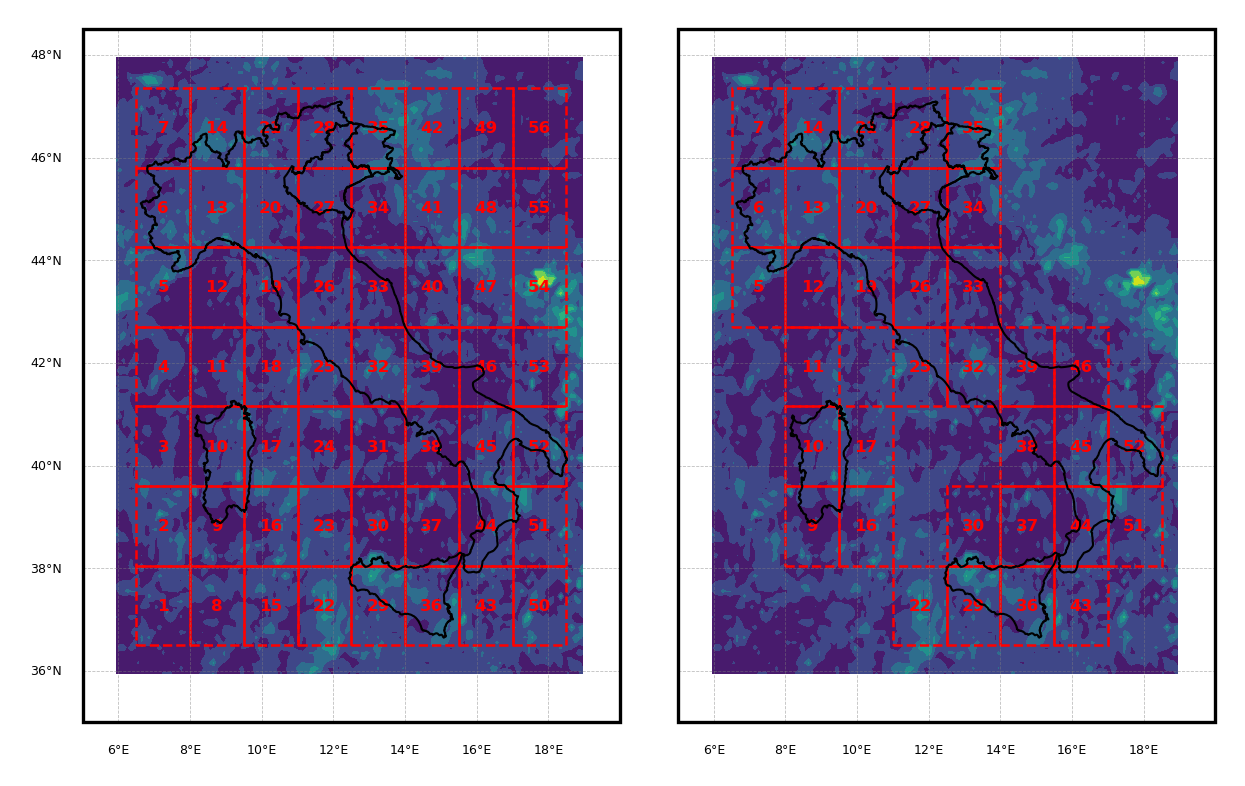

In [13]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(5,3),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([5, 20, 35, 48.5],crs=proj)
ITALY.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
a1 = ax1.contourf(lon2d, lat2d, PRE_data['PRE'].max(dim='time'))

contador = 1
for lon in lon_edges:
    for lat in lat_edges:
        if lon + delta_lon <= lon_max_total and lat + delta_lat <= lat_max_total:
            rect = patches.Rectangle(
                (lon, lat), delta_lon, delta_lat,
                linewidth=0.6, edgecolor='r', facecolor='none', linestyle='--'
            )
            ax1.add_patch(rect)
            
            lon_centro = lon + delta_lon / 2
            lat_centro = lat + delta_lat / 2
            ax1.text(lon_centro, lat_centro, str(contador), color='r', fontsize=4, ha='center', va='center', fontweight='bold')
            contador += 1  # Incrementar el identificador

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

# ==============================================================================
exclude = {1, 8, 15, 50, 2, 23, 3, 24, 31, 4, 18, 53, 47, 54, 40, 41, 48, 55, 42, 49, 56}
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([5, 20, 35, 48.5],crs=proj)
ITALY.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
a1 = ax1.contourf(lon2d, lat2d, PRE_data['PRE'].max(dim='time'))

id, lon_min, lon_max, lat_min, lat_max = [], [], [], [], []
contador = 1
for lon in lon_edges:
    for lat in lat_edges:
        if lon + delta_lon <= lon_max_total and lat + delta_lat <= lat_max_total:
            if contador in exclude:
                contador += 1
            else:
                rect = patches.Rectangle(
                    (lon, lat), delta_lon, delta_lat,
                    linewidth=0.6, edgecolor='r', facecolor='none', linestyle='--')

                ax1.add_patch(rect)

                lon_centro = lon + delta_lon / 2
                lat_centro = lat + delta_lat / 2
                ax1.text(lon_centro, lat_centro, str(contador), color='r', fontsize=4, ha='center', va='center', fontweight='bold')

                lon_min_ = lon
                lon_max_ = lon + delta_lon
                lat_min_ = lat
                lat_max_ = lat + delta_lat

                id.append(contador)
                lon_min.append(lon_min_)
                lon_max.append(lon_max_)
                lat_min.append(lat_min_)
                lat_max.append(lat_max_)

                contador += 1  # Incrementar el identificador

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

# ================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.05)


In [14]:
Mosaicos = pd.DataFrame({'Id':id, 'lon_min':lon_min, 'lon_max':lon_max, 'lat_min':lat_min, 'lat_max':lat_max})
Mosaicos.head(4)

,Id,lon_min,lon_max,lat_min,lat_max
0,5,6.5,8.0,42.70,44.25
1,6,6.5,8.0,44.25,45.80
2,7,6.5,8.0,45.80,47.35
3,9,8.0,9.5,38.05,39.60


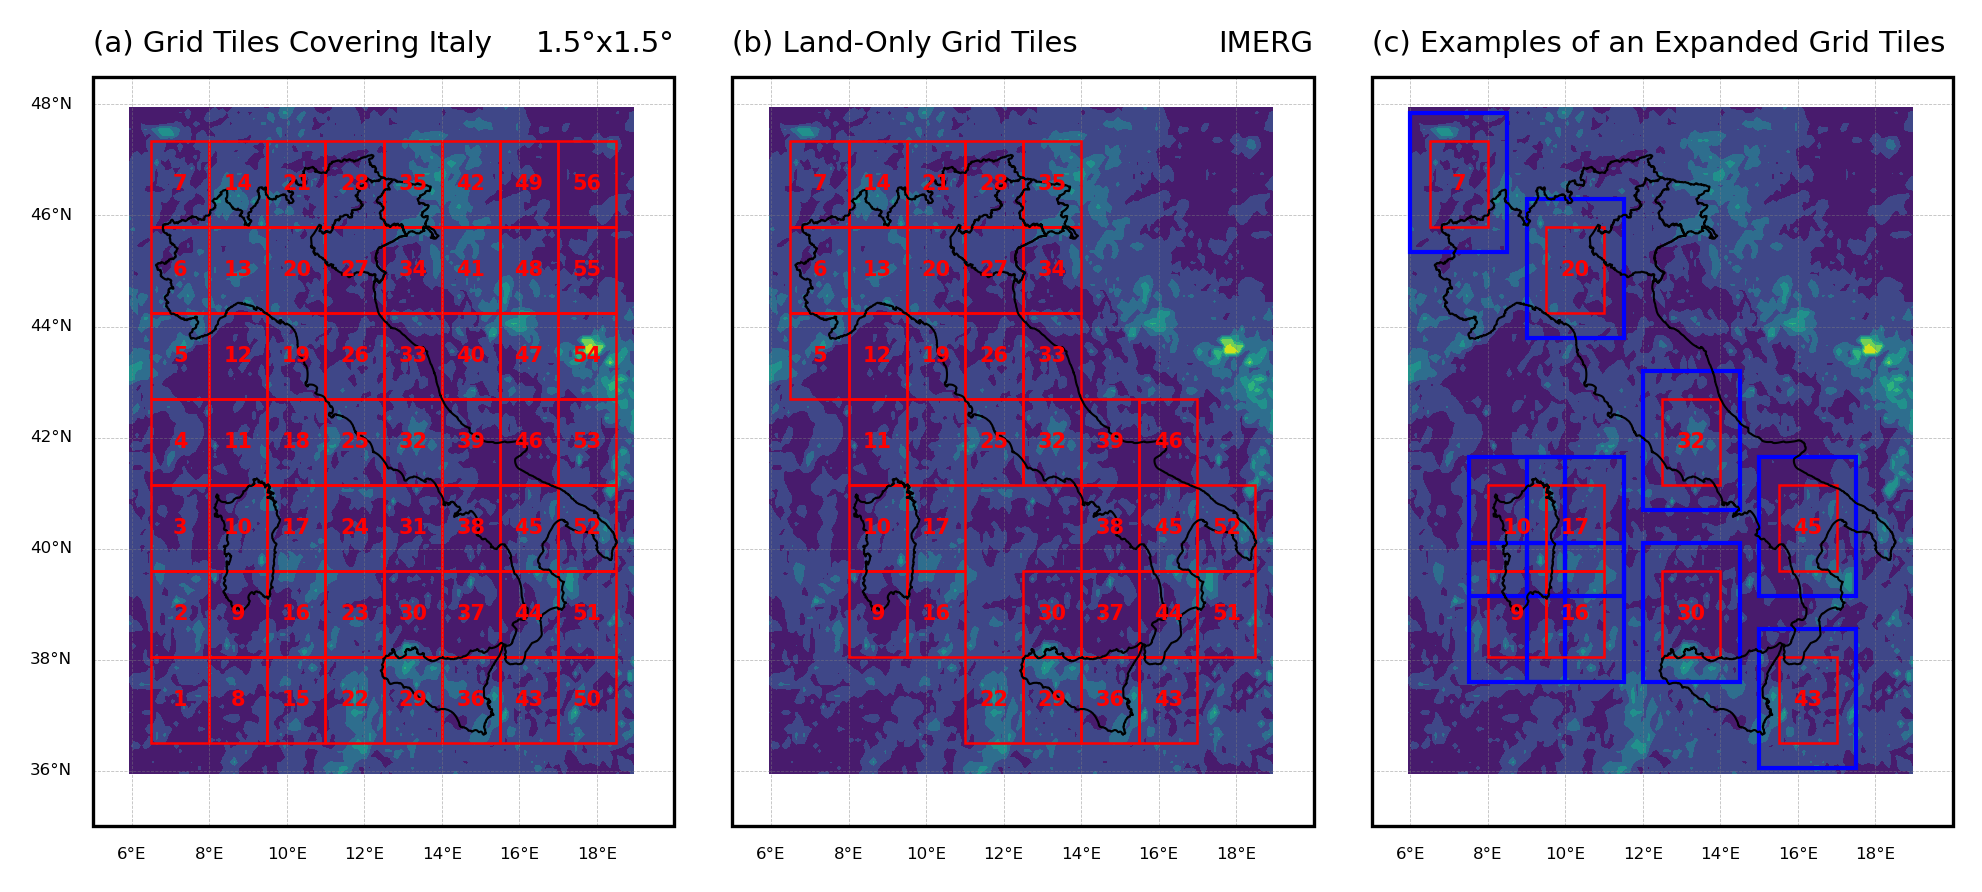

In [20]:
cmap = plt.cm.Spectral_r
cmap = None
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(8,4),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([5, 20, 35, 48.5],crs=proj)
ITALY.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
a1 = ax1.contourf(lon2d, lat2d, PRE_data['PRE'].max(dim='time'),cmap=cmap)

contador = 1
for lon in lon_edges:
    for lat in lat_edges:
        if lon + delta_lon <= lon_max_total and lat + delta_lat <= lat_max_total:
            rect = patches.Rectangle(
                (lon, lat), delta_lon, delta_lat,
                linewidth=0.6, edgecolor='r', facecolor='none', linestyle='-'
            )
            ax1.add_patch(rect)
            
            lon_centro = lon + delta_lon / 2
            lat_centro = lat + delta_lat / 2
            ax1.text(lon_centro, lat_centro, str(contador), color='r', fontsize=5, ha='center', va='center', fontweight='bold', zorder=20)
            contador += 1  # Incrementar el identificador

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title('(a) Grid Tiles Covering Italy', loc='left', fontsize=7)
ax1.set_title('1.5°x1.5°', loc='right', fontsize=7)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([5, 20, 35, 48.5],crs=proj)
ITALY.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
a1 = ax1.contourf(lon2d, lat2d, PRE_data['PRE'].max(dim='time'),cmap=cmap)

contador = 1
for nn in range(len(Mosaicos)):
    x_min = Mosaicos['lon_min'].values[nn]
    x_max = Mosaicos['lon_max'].values[nn]
    y_min = Mosaicos['lat_min'].values[nn]
    y_max = Mosaicos['lat_max'].values[nn]

    ax1.add_patch(patches.Rectangle((x_max,y_max),x_min-x_max,y_min-y_max,linestyle='-',
                                    linewidth=0.6,edgecolor='r',facecolor='None',zorder=5))

    lon_centro = (x_max + x_min) / 2
    lat_centro = (y_max + y_min) / 2
    ax1.text(lon_centro, lat_centro, str(Mosaicos['Id'].values[nn]), color='r', fontsize=5, ha='center', va='center', fontweight='bold', zorder=20)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title('(b) Land-Only Grid Tiles', loc='left', fontsize=7)
ax1.set_title('IMERG', loc='right', fontsize=7)

# ==============================================================================
include = {7, 9, 10, 16, 17, 20, 30, 32, 43, 45}
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([5, 20, 35, 48.5],crs=proj)
ITALY.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
VENETO.plot(facecolor='None', ax=ax1, zorder=10, linewidth=0.5)
a1 = ax1.contourf(lon2d, lat2d, PRE_data['PRE'].max(dim='time'),cmap=cmap)

contador = 1
for nn in range(len(Mosaicos)):
    x_min = Mosaicos['lon_min'].values[nn]
    x_max = Mosaicos['lon_max'].values[nn]
    y_min = Mosaicos['lat_min'].values[nn]
    y_max = Mosaicos['lat_max'].values[nn]

    if Mosaicos['Id'].values[nn] in include:
        ax1.add_patch(patches.Rectangle((x_max,y_max),x_min-x_max,y_min-y_max,linestyle='-',
                                        linewidth=0.6,edgecolor='r',facecolor='None',zorder=5))

        lon_centro = (x_max + x_min) / 2
        lat_centro = (y_max + y_min) / 2
        ax1.text(lon_centro, lat_centro, str(Mosaicos['Id'].values[nn]), color='r', fontsize=5, ha='center', va='center', fontweight='bold', zorder=20)

        delta = 0.5
        ax1.add_patch(patches.Rectangle((x_max+delta,y_max+delta),(x_min-delta)-(x_max+delta),(x_min-delta)-(x_max+delta),
                        linestyle='-',linewidth=1,edgecolor='b',facecolor='None',zorder=5))

    contador += 1  # Incrementar el identificador

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

ax1.set_title('(c) Examples of an Expanded Grid Tiles', loc='left', fontsize=7)

# ================================================================================================
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.1, wspace=0.1)
ax1.set_facecolor('white')
fig.patch.set_alpha(0)